In [305]:
import json
import importlib
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots
from src.plots import plot_quant_vs_ogtt, annotate_point

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import patches, transforms
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns 
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [366]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))

fr = pd.read_csv('../data/interim/Diet_study_final_results.csv')
fr.index = 'dl_' + fr.index.astype('str')
long_data_cols = fr.filter(regex='_T')
short_cols = fr.filter(regex='_T').columns.str.split('_T').str[1].str.split('M.').str[0]
col_map = {x: y for x, y in zip(long_data_cols, short_cols)}
data_cols = list(col_map.values())
col_map['Identification'] = 'ID'
col_map['Lipid Class'] = 'molec_class'

fr.rename(col_map, axis=1, inplace=True)

md = pd.read_csv('../data/metadata/Diet_study_sample_info.csv', index_col=0)
md.index = md.index.str[1:-1].astype('str')
md['animal'] = md.index
md['diabetic_str'] = md['Diabetic'].astype('str').str[:1]
md['last_meal'] = md['Diet'].str[-6:]
md['has_eaten_rodent'] = md['Diet'].str.contains('Rodent')
md['test_combo'] = md['has_eaten_rodent'].astype('str') + ' ' + md['last_meal']
md[['Diet', 'test_combo']]


ids = fr.loc[(fr['ID'].notna()) & (fr['Features Found'] > 5)]
ids = ids.loc[:, ['ID', 'molec_class'] + data_cols]
ids.loc[:, data_cols] = np.log2(ids[data_cols])
ids['superclass'] = ids['molec_class'].map(compound_superclasses)


def ttest(x, y):
    return scipy.stats.ttest_ind(x, y).pvalue

rod_last = md.loc[md['last_meal'] == 'Rodent'].index
rab_last = md.loc[md['last_meal'] == 'Rabbit'].index

ids['ttpval'] = ids.loc[:, data_cols].apply(lambda row: ttest(row[rod_last], row[rab_last]), axis=1)
ids['log_qval_tt'] = -np.log10(sm.stats.fdrcorrection(ids['ttpval'])[1])

gb = ids.loc[:, data_cols].groupby(md['last_meal'], axis=1).mean()

ids['last_meal_rab_mean'] = gb['Rabbit']
ids['last_meal_rod_mean'] = gb['Rodent']
ids['log2_fc_last_meal'] = ids['last_meal_rab_mean'] - ids['last_meal_rod_mean']



ids['log2_fc_rod-rab2rod'] = \
    ids.loc[:, md.loc[md['Diet'] == 'Rodent'].index].mean(axis=1) - \
    ids.loc[:, md.loc[md['Diet'] == 'Rabbit to Rodent'].index].mean(axis=1)

_, _, ids['fa_carbons'], ids['fa_unsat'], ids['fa_carbon:unsat'], _, ids['is_sum_comp'] = \
    zip(*ids['ID'].apply(src.utils.parse_lipid))

ids['Type'] = 'lipid'
ids['dummy'] = True
ids['i'] = ids.index
ids

,ID,molec_class,550,551,552,553,562,568,569,570,...,last_meal_rod_mean,log2_fc_last_meal,log2_fc_rod-rab2rod,fa_carbons,fa_unsat,fa_carbon:unsat,is_sum_comp,Type,dummy,i
dl_6,LysoPC 20:3,LysoPC,20.487097,21.103674,20.017513,19.174148,20.446944,20.522645,20.628916,20.277767,...,20.173800,-0.225425,0.653688,20.0,3.0,20:3,False,lipid,True,dl_6
dl_8,LysoPE 16:0,LysoPE,20.151722,19.891348,18.650360,16.853047,19.809907,19.586473,19.202995,18.980987,...,19.708978,-0.913469,-0.022026,16.0,0.0,16:0,False,lipid,True,dl_8
dl_17,LysoPC 16:0,LysoPC,26.632008,26.547750,25.592634,25.433008,26.346042,26.296141,26.271419,26.014782,...,26.383106,-0.394610,0.012220,16.0,0.0,16:0,False,lipid,True,dl_17
dl_23,LysoPC 18:1,LysoPC,23.876427,24.749192,23.202697,23.192204,24.448844,24.019031,24.323886,23.504458,...,24.234081,-0.824236,-0.276119,18.0,1.0,18:1,False,lipid,True,dl_23
dl_38,LysoPC 20:2,LysoPC,18.889908,19.841993,18.605774,18.220916,19.333497,18.827757,19.295765,18.883918,...,18.931293,-0.235158,0.057560,20.0,2.0,20:2,False,lipid,True,dl_38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dl_1161,TG 58:1,TG,19.875822,17.239229,17.245732,16.591645,16.307120,18.266749,17.396575,17.630223,...,17.804629,-1.463047,-0.241379,58.0,1.0,58:1,True,lipid,True,dl_1161
dl_1162,TG 60:2,TG,19.751953,17.225041,17.474676,17.529174,16.309665,18.381236,17.522842,17.925321,...,17.933750,-0.835312,-0.392959,60.0,2.0,60:2,True,lipid,True,dl_1162
dl_1164,TG 62:3,TG,17.966347,15.533979,16.100621,15.746582,12.900199,16.533821,15.629566,16.486049,...,15.877836,-0.444727,-0.375148,62.0,3.0,62:3,True,lipid,True,dl_1164
dl_1166,TG 59:1,TG,17.460475,14.269585,14.955145,13.449801,13.270160,15.789374,14.517362,14.927495,...,14.842175,-0.675170,-0.002232,59.0,1.0,59:1,True,lipid,True,dl_1166


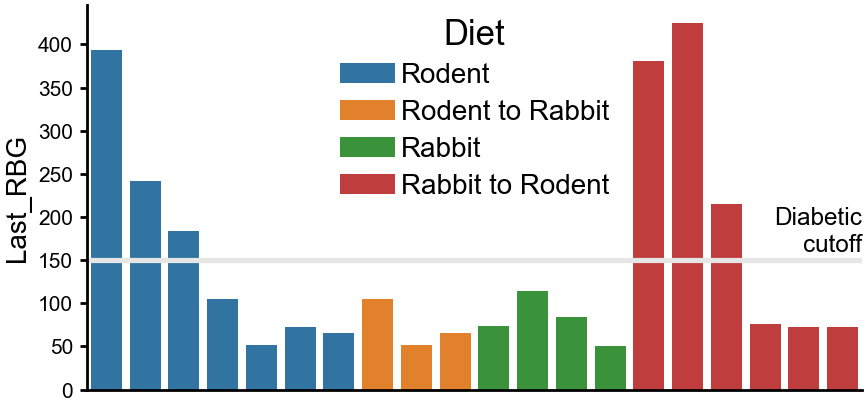

In [391]:
fig, ax = plt.subplots(dpi=250, figsize=(4, 2))
sns.barplot(
    data=md, x='animal', y='Last_RBG', hue='Diet', dodge=False, ax=ax,
)
# ax.set_xticks(range(len(md)), md['diabetic_str'])
# ax.set_xlabel('Animal is Diabetic')
ax.set_xticks([])
ax.set_xlabel(None)
ax.axhline(150, zorder=2, color='0.9')
ax.text(19.5, 160, 'Diabetic\ncutoff', ha='right', fontsize=7)
sns.despine()

In [300]:
data = (md.loc[:, ['animal', 'Diet', 'Last_RBG', 'Mean_RBG', 'HbA1c', 'Diabetic',
                   'has_eaten_rodent', 'last_meal']]
          .join(ids.loc[:, data_cols]
          .T)
       )
data

,animal,Diet,Last_RBG,Mean_RBG,HbA1c,Diabetic,has_eaten_rodent,last_meal,dl_6,dl_8,...,dl_1147,dl_1149,dl_1151,dl_1156,dl_1159,dl_1161,dl_1162,dl_1164,dl_1166,dl_1167
Nile_rat_ID,,,,,,,,,,,,,,,,,,,,,
550,550,Rodent,394,249.666667,5.9,True,True,Rodent,20.487097,20.151722,...,20.479269,20.277926,20.070311,18.827340,19.026612,19.875822,19.751953,17.966347,17.460475,17.741429
571,571,Rodent,242,217.333333,5.2,True,True,Rodent,20.100758,19.653426,...,19.251575,19.251543,18.027872,16.761030,16.718608,18.077413,17.716507,16.306785,15.339217,15.972057
582,582,Rodent,184,154.000000,4.9,True,True,Rodent,20.038479,19.595813,...,18.187503,18.015622,17.732175,15.984208,16.480340,16.689655,17.359443,15.062138,13.241843,13.733815
551,551,Rodent,105,96.666667,4.0,False,True,Rodent,21.103674,19.891348,...,18.099731,17.830347,17.953609,16.159749,16.421331,17.239229,17.225041,15.533979,14.269585,15.314769
562,562,Rodent,52,71.666667,4.0,False,True,Rodent,20.446944,19.809907,...,17.652951,17.265052,16.927512,14.408768,13.662030,16.307120,16.309665,12.900199,13.270160,13.942925
568,568,Rodent,73,66.666667,NaN,False,True,Rodent,20.522645,19.586473,...,19.341583,19.355811,18.778522,17.201042,17.389142,18.266749,18.381236,16.533821,15.789374,16.415992
569,569,Rodent,65,78.000000,NaN,False,True,Rodent,20.628916,19.202995,...,18.784023,18.065110,17.914349,16.123167,16.574959,17.396575,17.522842,15.629566,14.517362,15.677407
553,553,Rodent to Rabbit,105,96.666667,4.0,False,True,Rabbit,19.174148,16.853047,...,17.501645,18.887290,18.711370,16.520938,16.629906,16.591645,17.529174,15.746582,13.449801,14.053600
552,552,Rodent to Rabbit,52,70.666667,4.0,False,True,Rabbit,20.017513,18.650360,...,17.693546,18.552473,18.526836,16.702122,17.291726,17.245732,17.474676,16.100621,14.955145,14.663223


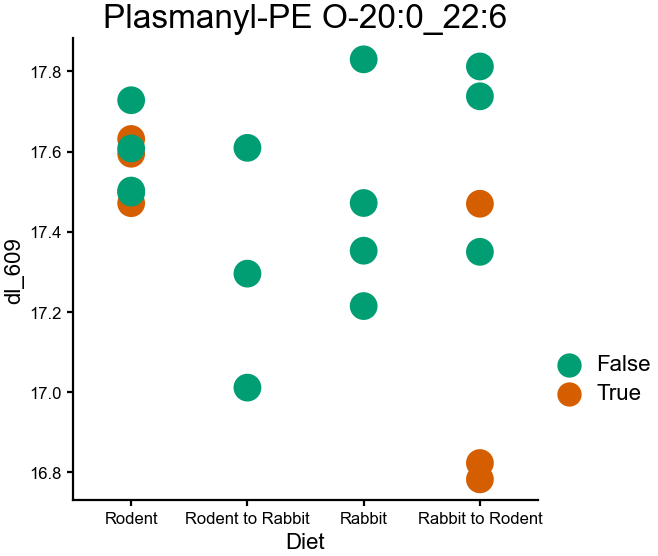

In [117]:
fig, ax = plt.subplots(dpi=200, figsize=(3,3))
feature = ids.sample(1).index[0]
sns.stripplot(
    data=data, x='Diet', y=feature, 
    hue='Diabetic', dodge=False, jitter=False,
    palette={True: colors['diabetic'], False: colors['normal']}, 
    size=10,
)
ax.set_title(ids.loc[feature, 'ID'])
ax.legend(loc=(1.01, 0.2))
sns.despine()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dl_1080   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     25.31
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           8.00e-06
Time:                        17:31:02   Log-Likelihood:                -20.165
No. Observations:                  20   AIC:                             46.33
Df Residuals:                      17   BIC:                             49.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               23.2978      0.272     85.692      0.000      22.724      23.871
last_meal[T.Rodent]                      1.5986      0.384      4.158      0.001       0.787       2.410
Diabetic[T.True]                         0.6136      0.200      3.067      0.007       0.191       1.036
last_meal[T.Rodent]:Diabetic[T.True]     0.6136      0.200      3.067      0.007       0.191       1.036
==============================================================================
Omnibus:                        1.209   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.546   Jarque-Bera (JB):                0.934
Skew:                          -0.257   Prob(JB):                        0.627
Kurtosis:                       2.074   Cond. No.                     2.88e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.31e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

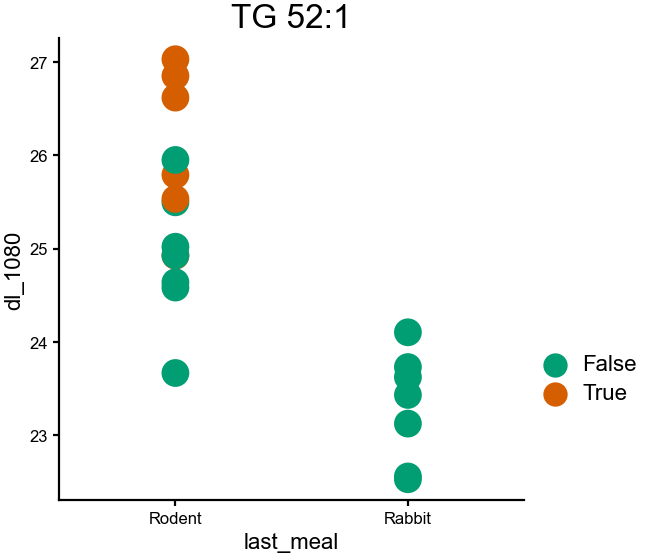

In [383]:
fig, ax = plt.subplots(dpi=200, figsize=(3,3))
feature = ids.sample(1).index[0]
sns.stripplot(
    data=data, x='last_meal', y=feature, 
    hue='Diabetic', dodge=False, jitter=False,
    palette={True: colors['diabetic'], False: colors['normal']}, 
    size=10,
)
ax.set_title(ids.loc[feature, 'ID'])
ax.legend(loc=(1.01, 0.2))
sns.despine()

smf.ols(f'{feature} ~ (last_meal + Diabetic)**2', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dl_381   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.039
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.149
Time:                        15:49:41   Log-Likelihood:                -26.215
No. Observations:                  20   AIC:                             60.43
Df Residuals:                      16   BIC:                             64.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       18.2979      1.347     13.580      0.000      15.442      21.154
last_meal[T.Rodent]              1.1578      1.427      0.811      0.429      -1.867       4.182
Last_RBG                         0.0053      0.017      0.319      0.754      -0.030       0.040
last_meal[T.Rodent]:Last_RBG    -0.0035      0.017     -0.207      0.839      -0.039       0.032
==============================================================================
Omnibus:                        3.875   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                2.468
Skew:                           0.857   Prob(JB):                        0.291
Kurtosis:                       3.151   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

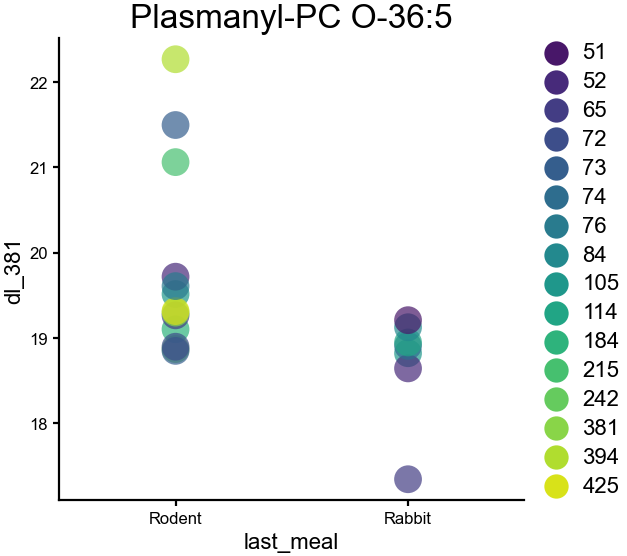

In [177]:
fig, ax = plt.subplots(dpi=200, figsize=(3,3))
feature = ids.sample(1).index[0]
sns.stripplot(
    data=data, x='last_meal', y=feature, 
    hue='Last_RBG', 
#     style='Diet', 
#     palette={True: colors['diabetic'], False: colors['normal']}, 
    palette='viridis',
    size=10, dodge=False, jitter=False, alpha=0.7,
)
ax.set_title(ids.loc[feature, 'ID'])
ax.legend(loc=(1.01, 0.0))
sns.despine()

smf.ols(f'{feature} ~ last_meal + Last_RBG + last_meal:Last_RBG', 
        data=data).fit().summary()

In [396]:
ax.scatter

<bound method Axes.scatter of <AxesSubplot:>>

In [400]:
data

,animal,Diet,Last_RBG,Mean_RBG,HbA1c,Diabetic,has_eaten_rodent,last_meal,dl_6,dl_8,...,dl_1147,dl_1149,dl_1151,dl_1156,dl_1159,dl_1161,dl_1162,dl_1164,dl_1166,dl_1167
Nile_rat_ID,,,,,,,,,,,,,,,,,,,,,
550,550,Rodent,394,249.666667,5.9,True,True,Rodent,20.487097,20.151722,...,20.479269,20.277926,20.070311,18.827340,19.026612,19.875822,19.751953,17.966347,17.460475,17.741429
571,571,Rodent,242,217.333333,5.2,True,True,Rodent,20.100758,19.653426,...,19.251575,19.251543,18.027872,16.761030,16.718608,18.077413,17.716507,16.306785,15.339217,15.972057
582,582,Rodent,184,154.000000,4.9,True,True,Rodent,20.038479,19.595813,...,18.187503,18.015622,17.732175,15.984208,16.480340,16.689655,17.359443,15.062138,13.241843,13.733815
551,551,Rodent,105,96.666667,4.0,False,True,Rodent,21.103674,19.891348,...,18.099731,17.830347,17.953609,16.159749,16.421331,17.239229,17.225041,15.533979,14.269585,15.314769
562,562,Rodent,52,71.666667,4.0,False,True,Rodent,20.446944,19.809907,...,17.652951,17.265052,16.927512,14.408768,13.662030,16.307120,16.309665,12.900199,13.270160,13.942925
568,568,Rodent,73,66.666667,NaN,False,True,Rodent,20.522645,19.586473,...,19.341583,19.355811,18.778522,17.201042,17.389142,18.266749,18.381236,16.533821,15.789374,16.415992
569,569,Rodent,65,78.000000,NaN,False,True,Rodent,20.628916,19.202995,...,18.784023,18.065110,17.914349,16.123167,16.574959,17.396575,17.522842,15.629566,14.517362,15.677407
553,553,Rodent to Rabbit,105,96.666667,4.0,False,True,Rabbit,19.174148,16.853047,...,17.501645,18.887290,18.711370,16.520938,16.629906,16.591645,17.529174,15.746582,13.449801,14.053600
552,552,Rodent to Rabbit,52,70.666667,4.0,False,True,Rabbit,20.017513,18.650360,...,17.693546,18.552473,18.526836,16.702122,17.291726,17.245732,17.474676,16.100621,14.955145,14.663223


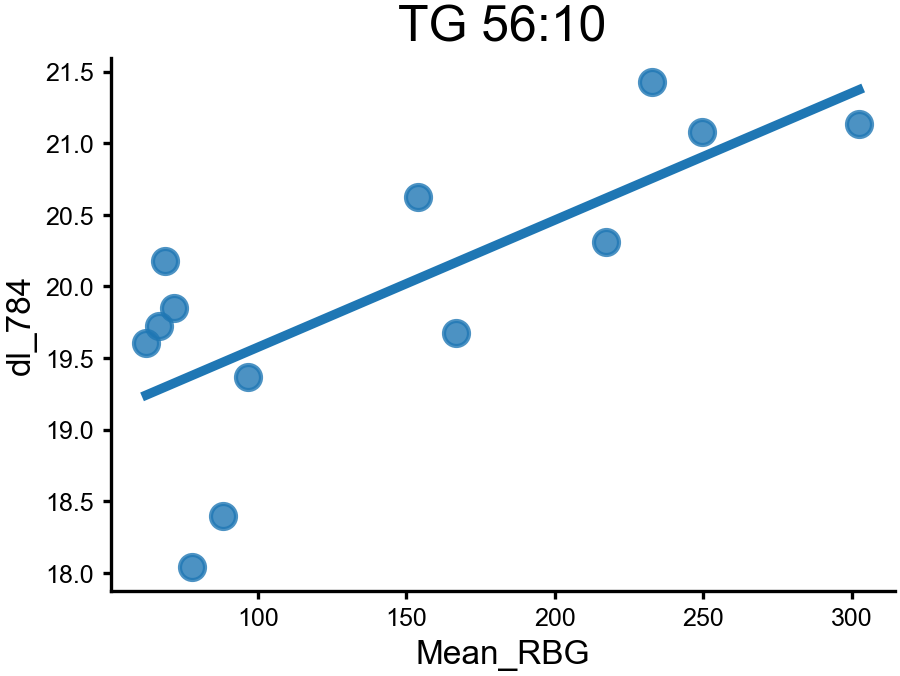

In [625]:
# fig, ax = plt.subplots(dpi=200, figsize=(3,3))
# feature = ids.loc[ids['molec_class'].str.contains('P')].sample(1).index[0]
feature = ids.sample(1).index[0]

sns.lmplot(
    data=data.loc[(data['Diet'].isin(['Rodent', 'Rabbit to Rodent'])) 
#                   & (data['molec_class'].str.contains('P'))
                 ],
    x='Mean_RBG', y=feature, #scatter_kws=dict(color='red'),
#     hue='Diet', 
    ci=None,
)
plt.gca().set_title(ids.loc[feature, 'ID'])
plt.gcf().set_size_inches(3, 2)
plt.gcf().set_dpi(300)
# plt.gcf().legend(loc=(0.85, 0.1))
sns.despine()

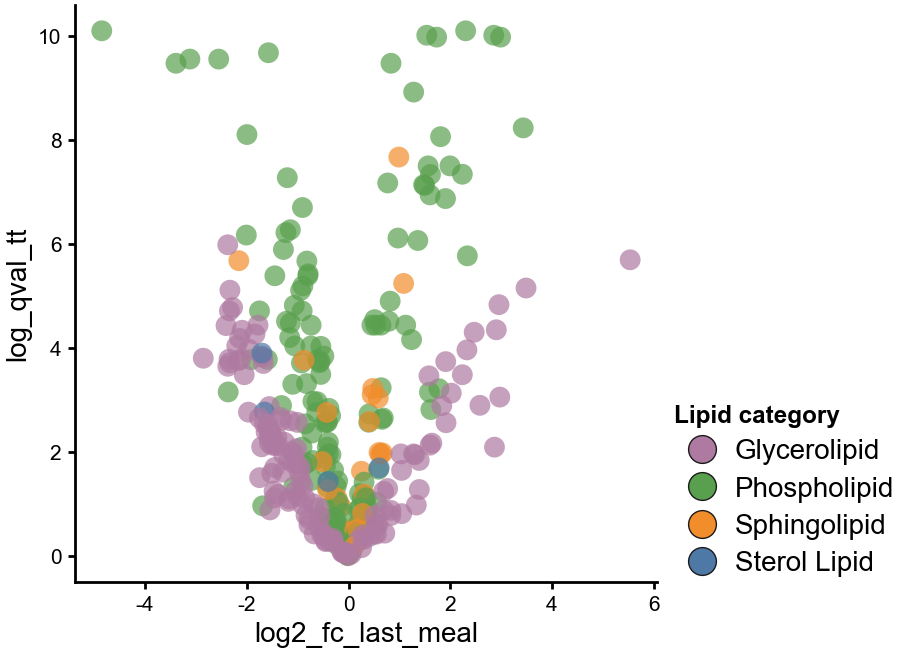

In [304]:
fig, ax = plt.subplots(dpi=250, figsize=(3, 3))

sns.scatterplot(
    data=ids, x='log2_fc_last_meal', y='log_qval_tt', ax=ax, hue='superclass', palette=colors,
    linewidth=0, alpha=0.7
)
legend = src.plots.custom_legend(ids['superclass'].unique(), ax=ax, title='Lipid category')
sns.despine()

In [311]:
px.scatter(
   data_frame=ids, x='log2_fc_last_meal', y='log_qval_tt', color='superclass', 
    hover_data=['ID', 'i', 'molec_class'], 
)

In [336]:
ids['log2_fc_last_meal']

dl_6      -0.225425
dl_8      -0.913469
dl_17     -0.394610
dl_23     -0.824236
dl_38     -0.235158
             ...   
dl_1161   -1.463047
dl_1162   -0.835312
dl_1164   -0.444727
dl_1166   -0.675170
dl_1167   -1.388627
Name: log2_fc_last_meal, Length: 321, dtype: float64

(<AxesSubplot:xlabel='TG fatty acyl carbons', ylabel='TG fatty acyl unsaturations'>,
 <matplotlib.colorbar.Colorbar at 0x2abe6c91948>)

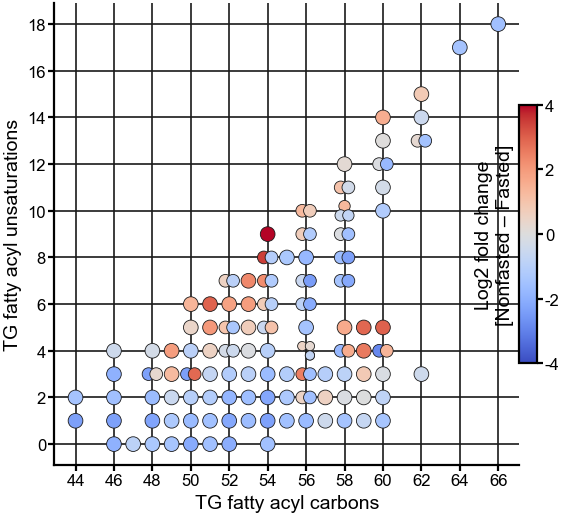

In [370]:
importlib.reload(src.plots)

fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
src.plots.carbon_unsat(
    df=ids, lipid_class='TG', ax=ax, jitter_offset=0.2, 
    hue='log2_fc_last_meal', halfrange=4,
)

(<AxesSubplot:xlabel='TG fatty acyl carbons', ylabel='TG fatty acyl unsaturations'>,
 <matplotlib.colorbar.Colorbar at 0x2abeb3da148>)

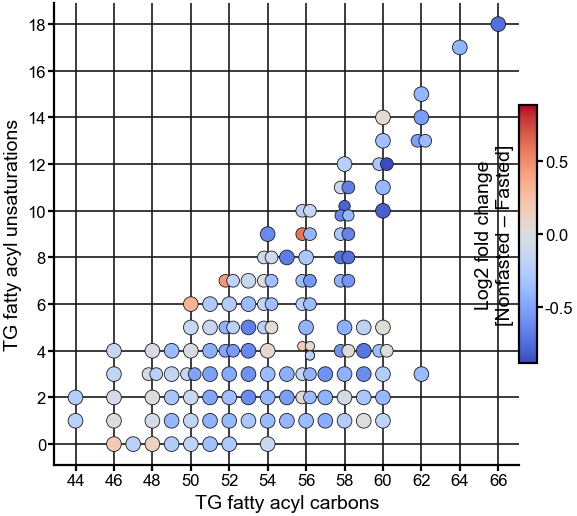

In [372]:
fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
src.plots.carbon_unsat(
    df=ids, lipid_class='TG', ax=ax, jitter_offset=0.2, 
    hue='log2_fc_rod-rab2rod', # halfrange=4,
)


(<AxesSubplot:xlabel='PC fatty acyl carbons', ylabel='PC fatty acyl unsaturations'>,
 <matplotlib.colorbar.Colorbar at 0x2abe7d92b08>)

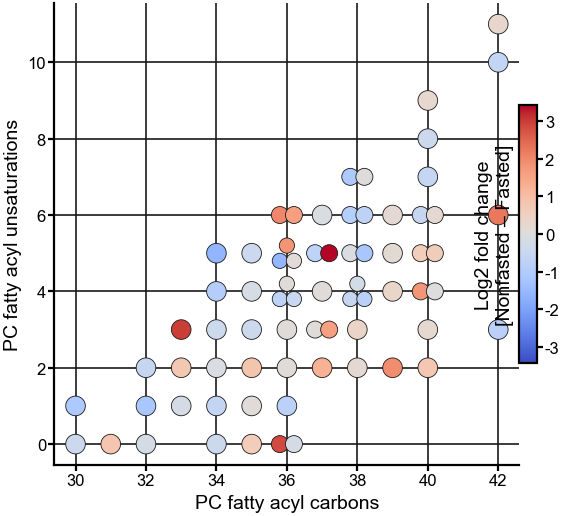

In [354]:
fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
src.plots.carbon_unsat(
    df=ids, lipid_class='PC', ax=ax, jitter_offset=0.2, 
    hue='log2_fc_last_meal', base_size=50,
)

(<AxesSubplot:xlabel="['Plasmanyl-PC', 'Plasmenyl-PC'] fatty acyl carbons", ylabel="['Plasmanyl-PC', 'Plasmenyl-PC'] fatty acyl unsaturations">,
 <matplotlib.colorbar.Colorbar at 0x2abea582f08>)

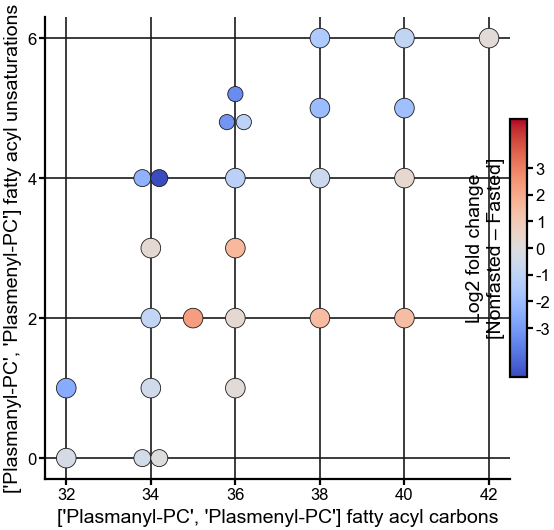

In [353]:
importlib.reload(src.plots)
importlib.reload(src.utils)

fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
src.plots.carbon_unsat(
    df=ids, lipid_class=['Plasmanyl-PC', 'Plasmenyl-PC'], ax=ax, jitter_offset=0.2, 
    hue='log2_fc_last_meal', base_size=50,
)

In [348]:
ids['molec_class'].value_counts()

TG              134
PC               71
Plasmanyl-PC     22
SM               20
Plasmenyl-PE     17
PI               13
PE                8
Plasmanyl-PE      7
LysoPC            7
Cer[NS]           5
PC[OH]            4
Plasmenyl-PC      4
CE                4
LysoPE            2
Alkenyl-DG        1
PE-NMe2           1
HexCer[NS]        1
Name: molec_class, dtype: int64